In [1]:
# import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
import json
import sys
import os
import re
import pprint
import time
import copy
from bs4 import BeautifulSoup
import seaborn as sn

%matplotlib inline

In [2]:
# create the data directory, remove the files if they exits
folder_name = "./data"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
else:
    for i in os.scandir(folder_name):
        try:
            os.remove(i)
        except:
            continue

In [3]:
# get the data from url
image_prediction_url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv"
twitter_archive_enhanced_url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/twitter-archive-enhanced.csv"
tweet_json_url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/tweet_json.txt"

In [4]:
# get the data by using a function
def get_data(url, path):
    """
    get the data from the url. Return the path of the data
    file
    
    Args:
    (str) url - the data address on the web
    (str) path - the parent path which stores the data
    
    Returns:
    (str) result - the file path which store the data
    """
    
    result = os.path.join(path, os.path.basename(url))
    
    url_request = requests.get(url)
    
    with open(result, "wb") as file:
        file.write(url_request.content)
    # adjust the sleep time to increase requesting interval
    time.sleep(3)
    return result

In [5]:
# get the datas by using the url and the function
if True:
    image_prediction = get_data(image_prediction_url, folder_name)
    twitter_archive_enhanced = get_data(twitter_archive_enhanced_url, folder_name)
    tweet_json = get_data(tweet_json_url, folder_name)
else:
    image_prediction = "./data/image-predictions.tsv"
    twitter_archive_enhanced = "./data/twitter-archive-enhanced.csv"
    tweet_json = "./data/tweet_json.txt"

In [6]:
# compare the files, which does just check the files
import filecmp
if False:
    print(filecmp.cmp(image_prediction, "./Test/image-predictions.tsv"), 
          filecmp.cmp(twitter_archive_enhanced, "./Test/twitter-archive-enhanced.csv"),
          filecmp.cmp(tweet_json, "./Test/tweet_json.txt"))

### 1. 收集数据
1. 本次项目中数据已经由 `project` 给出了相关的下载链接，因此先直接使用了 `requests` 库获取相关的数据，保留了原始的文件名。另外因为是对数据获取是使用 `requests` 进行下载，通过完全将数据通过 `binary` 写入文件。为了验证得到数据的准确性，使用了 `filecmp` 对直接下载的数据和 `requests` 得到的数据进行比较。

2. 本次项目中得到了三种类型文件： `csv`, `tsv` 以及 `txt`。前两种文件类型比较容易处理，通过 `pandas` 的相关读取方法即可得到数据内容；但是 `txt` 的文件比较有难度，体现在——a）文件内容其实是 `json` 类型的；b）通过 `open` 的方式读取得到的数据是一个字符串，需要对数据内容进行相关处理。c）对数据进行相关的提取，一方面是因为在实际情况中并非是所有的数据都是必须的。对某些数据需要合适转换才能完成数据完整读取

In [7]:
# load the datas
twitter_archive_data = pd.read_csv(twitter_archive_enhanced)

image_prediction_data = pd.read_csv(image_prediction, sep="\t")

In [8]:
tweet_data = pd.DataFrame()
index_count = -1

with open(tweet_json, "rb") as file:
    for i in file.readlines():
        temp = []
        dict_data = json.loads(i)
        temp.append({"id": dict_data["id"], 
                     "created_at": dict_data["created_at"], 
                     "full_text": dict_data["full_text"], 
                     "retweet_count":dict_data["retweet_count"], 
                     "favorite_count":dict_data["favorite_count"],
                     "in_reply_to_user_id": dict_data["in_reply_to_user_id"],
                     "in_reply_to_status_id": dict_data["in_reply_to_status_id"],
                     "source": dict_data["source"]})
        # maybe dict data can't contain the key
        try:
            temp[0]["media_url"] =  dict_data["entities"]["media"][0]["media_url_https"]
        except KeyError:
            temp[0]["media_url"] =  None
            
        try:
            temp[0]["expanded_url"] =  dict_data["extended_entities"]["media"][0]["expanded_url"]
        except KeyError:
            temp[0]["expanded_url"] =  None
            
            
        temp = pd.DataFrame(temp, columns=["id", "created_at", "full_text", "media_url",
                                           "favorite_count", "retweet_count", "in_reply_to_status_id",
                                           "in_reply_to_user_id", "expanded_url", "source"],
                            index=pd.Index([index_count+1]))
        tweet_data = pd.concat([tweet_data, temp])
        
        # increase the index value
        index_count += 1

In [9]:
# print the keys
def print_fields(column_data, name):
    """
    display the information about the data fields
    
    Args:
    (Array) column_data - the fields about the data
    (str) name - the name of the data variable
    
    Returns:
    (None)
    """    
    print("There are %d fields in the %s:\n" % (len(column_data), name))

    for i, key in enumerate(column_data):
        print("{0:<2}\t{1:<30}".format(i+1, key))

In [10]:
# image_prediction_data
print_fields(image_prediction_data.columns, "image_prediction_data")

There are 12 fields in the image_prediction_data:

1 	tweet_id                      
2 	jpg_url                       
3 	img_num                       
4 	p1                            
5 	p1_conf                       
6 	p1_dog                        
7 	p2                            
8 	p2_conf                       
9 	p2_dog                        
10	p3                            
11	p3_conf                       
12	p3_dog                        


In [11]:
# twitter_archive_data
print_fields(twitter_archive_data.columns, "twitter_archive_data")

There are 17 fields in the twitter_archive_data:

1 	tweet_id                      
2 	in_reply_to_status_id         
3 	in_reply_to_user_id           
4 	timestamp                     
5 	source                        
6 	text                          
7 	retweeted_status_id           
8 	retweeted_status_user_id      
9 	retweeted_status_timestamp    
10	expanded_urls                 
11	rating_numerator              
12	rating_denominator            
13	name                          
14	doggo                         
15	floofer                       
16	pupper                        
17	puppo                         


In [12]:
# tweet_data
print_fields(tweet_data.columns, "tweet_data")

There are 10 fields in the tweet_data:

1 	id                            
2 	created_at                    
3 	full_text                     
4 	media_url                     
5 	favorite_count                
6 	retweet_count                 
7 	in_reply_to_status_id         
8 	in_reply_to_user_id           
9 	expanded_url                  
10	source                        


### 2. 评估数据
#### 2.1 对数据的 `field` 进行评估
对 `tsv` 和 `csv` 文件采取了直接使用 `pandas` 读取数据，直接得到了两者的 `field`：其中 `image-prediction.tsv` 中有 `12` 个 `fields`，得到的结果如下：

1. tweet_id : 推特链接中位于 "status/" 后面的一部分
2. jpg_url:预测的图像资源链接
3. img_num : 最可信的预测结果对应的图像编号
4. p1 : 是算法对推特中图片的一号预测
5. p1_conf : 是算法预测的可信度
6. p1_dog : 预测该图片是否属于“狗”
7. p2 : 算法对推特中图片预测的第二种可能性
8. p2_conf : 第二种算法的预测的可信度
9. p2_dog : 第二种算法预测该图片是否属于“狗”
10. p3 : 算法对推特中图片预测的第三种可能性
11. p3_conf : 第三种算法的预测的可信度
12. p3_dog : 第三种算法预测该图片是否属于“狗”


而 `twitter-archive-enhanced.csv` 中有 `17` 个 `fields`，得到的结果如下：

1. tweet_id : 推特链接中位于 "status/" 后面的最后一部分
2. in_reply_to_status_id : 代表是否有回复，如果有保留了 `tweet_id` 的数据，以数字形式保存
3. in_reply_to_user_id : 代表是否有回复，如果有保留了 `tweet_id` 的数据，以字符串形式保存
4. timestamp : 创建时间
5. source : 发送本条 `tweet` 时的设备信息，以 `HTML` 标签样式保存数据
6. text : 发送的 `tweet` 信息，以 `utf-8` 的字符串形式保存数据
7. retweeted_status_id : 第一个转 `tweet` 用户的信息
8. retweeted_status_user_id : 第一个转 `tweet` 用户的信息
9. retweeted_status_timestamp : 第一个转 `tweet` 用户的信息中的时间
10. expanded_urls : `tweet` 的 `entities` 中 `url`
11.	rating_numerator : 评分分数的分子
12.	rating_denominator : 评分分数的分母
13.	name : 狗的品种名称
14.	doggo : 狗是否属于该类型
15.	floofer : 狗是否属于该类型
16.	pupper : 狗是否属于该类型
17.	puppo : 狗是否属于该类型


因为 `tweet_json.txt` 文件需要将数据转化为 `json` 类型，额外提取相关数据信息进行组合。本次提取数据是参考以上两个文件中的已有的 `field` 进行分析，一方面是想通过该数据验证以上数据是否正确，另一方面也是为了验证数据清洗的结果是否合理及正确。具体提取的 `field` 如下：

1. id : 推特链接中位于 "status/" 后面的最后一部分，以数字形式保存
2. created_at : `tweet` 发送时间
3. full_text : 发送的 `tweet` 信息，以 `utf-8` 的字符串形式保存数据
4. media_url : 狗的图像资源链接
5. favorite_count : 表示被 `twitter` 用户喜欢的数量
6. retweet_count : 表示被转发 `tweet` 的数量
7. in_reply_to_status_id : 代表是否有回复，如果有保留了 `tweet_id` 的数据，以数字形式保存
8. in_reply_to_user_id : 代表是否有回复，如果有保留了 `tweet_id` 的数据，以字符串形式保存
9. expanded_url : 
10. source : 发送本条 `tweet` 时的设备信息，以 `HTML` 标签样式保存数据


In [13]:
pprint.pprint(dict_data)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sun Nov 15 22:32:08 +0000 2015',
 'display_text_range': [0, 131],
 'entities': {'hashtags': [],
              'media': [{'display_url': 'pic.twitter.com/BLDqew2Ijj',
                         'expanded_url': 'https://twitter.com/dog_rates/status/666020888022790149/photo/1',
                         'id': 666020881337073664,
                         'id_str': '666020881337073664',
                         'indices': [108, 131],
                         'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
                         'media_url_https': 'https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
                         'sizes': {'large': {'h': 720,
                                             'resize': 'fit',
                                             'w': 960},
                                   'medium': {'h': 720,
                                              'resize': 'fit',
                                  

In [14]:
def detect_data(df, name):
    """
    detect the data information about missing value, data types
    and unique values
    
    Args:
    (dataframe) df - dataframe storing the data
    (str) name - variable name referring  the data
    
    Returns:
    (None)
    """
    print("The summary information:\n")
    print("There are %d fiels and %d data points in the %s.\n" % (df.shape[1], df.shape[0], name))
    print("=" * 80)
    
    print("The missing_value information about the %s:\n" % name)
    print(df.isnull().sum())
    print("=" * 80)

    print("The unique value about every field:\n")
    
    for i in df.columns:
        print("The %s field with %s dtype has unique values:\n" % (i, df[i].dtypes))
        if len(df[i].unique()) > 5:
            print(",\n".join([str(df[i].unique()[element]) for element in range(5)]))
        else:
            print(",\n".join([str(element) for element in df[i].unique()]))
        print("-" * 80 + "\n")

    print("=" * 80)

In [15]:
detect_data(image_prediction_data, "image_prediction_data")

The summary information:

There are 12 fiels and 2075 data points in the image_prediction_data.

The missing_value information about the image_prediction_data:

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64
The unique value about every field:

The tweet_id field with int64 dtype has unique values:

666020888022790149,
666029285002620928,
666033412701032449,
666044226329800704,
666049248165822465
--------------------------------------------------------------------------------

The jpg_url field with object dtype has unique values:

https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,
https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,
https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,
https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,
https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
--------------------------------------------------------------------------------

Th

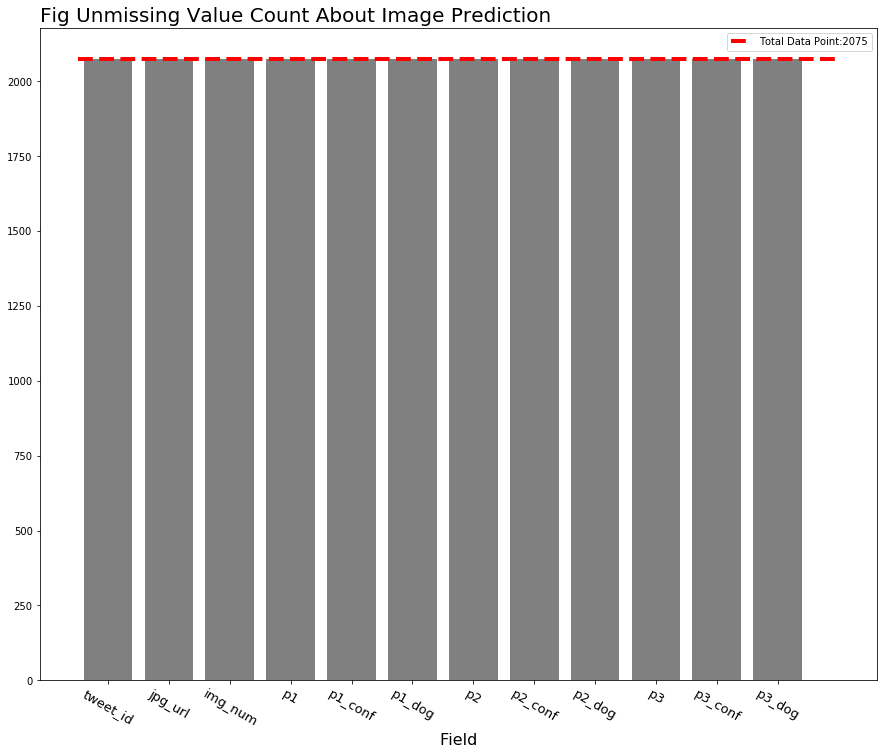

In [16]:
# plot the missing value hist plot
x_axis = image_prediction_data.columns.get_values()
height = image_prediction_data.count() - image_prediction_data.isnull().sum()

plt.figure(figsize=(15, 12))
plt.bar(np.arange(len(x_axis)), height, tick_label=x_axis, facecolor="grey", width=.8)
loc, labels = plt.xticks(rotation=330, fontsize=13)
plt.xlabel("Field", fontsize=16)

plt.hlines(y=2075, xmin=-0.5, xmax=loc.max()+1,colors="r", linestyles="--", linewidth=4,label="Total Data Point:2075")
plt.legend()
plt.title("Fig Unmissing Value Count About Image Prediction", loc="left", fontsize=20)
plt.show()

In [17]:
detect_data(twitter_archive_data, "twitter_archive_data")

The summary information:

There are 17 fiels and 2356 data points in the twitter_archive_data.

The missing_value information about the twitter_archive_data:

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64
The unique value about every field:

The tweet_id field with int64 dtype has unique values:

892420643555336193,
892177421306343426,
891815181378084864,
891689557279858688,
891327558926688256
-----------------------------------------

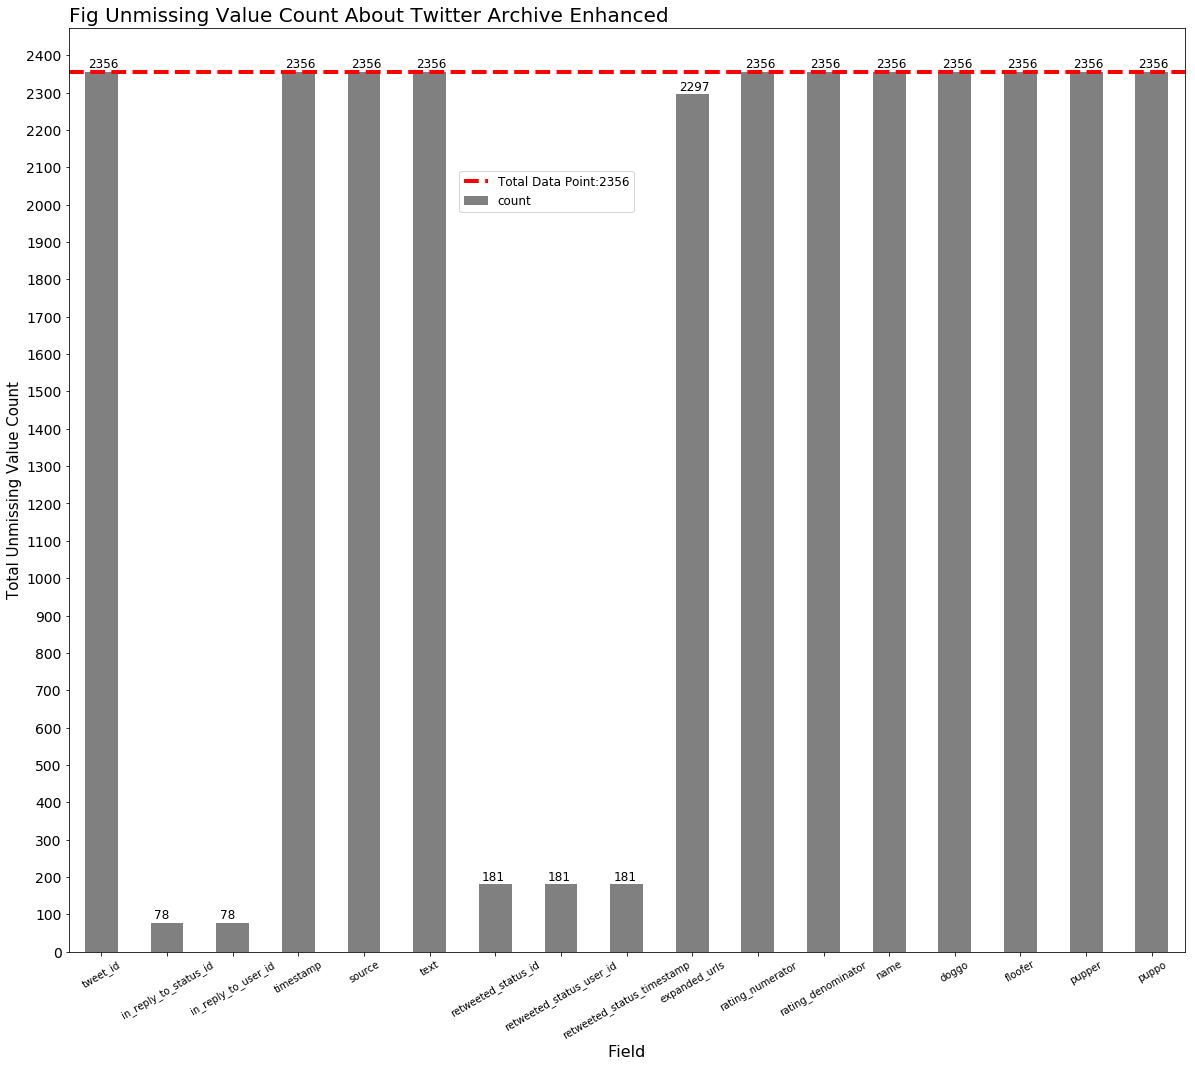

In [18]:
# plot the missing value hist plot
x_axis = twitter_archive_data.columns.get_values()
height = len(twitter_archive_data) - twitter_archive_data.isnull().sum()
hist_data = pd.DataFrame({"field": height.index.values, "count":height.values}, columns=["field", "count"])

hist_data.plot(x="field", kind="bar", figsize=(20, 17), rot=30, color="grey") #, yticks=np.arange(height.min()-500, height.max()+200, 300))
plt.xlabel("Field", fontsize=16)
loc, labels = plt.xticks( fontsize=10)
plt.ylabel("Total Unmissing Value Count", fontsize=15)
plt.yticks(np.arange(0, height.max()+200, 100), fontsize=14)
plt.title("Fig Unmissing Value Count About Twitter Archive Enhanced", loc="left", fontsize=20)


for x, y, s in zip(loc, [i + 10 for i in height], [str(i) for i in height]):
    plt.text(x-0.2, y, s, fontsize=12)
    
plt.hlines(y=2356, xmin=-0.5, xmax=loc.max()+1,colors="r",
           linestyles="--", linewidth=4,label="Total Data Point:2356")

plt.legend(loc=(0.35, 0.8), fontsize="large")
plt.show()

In [19]:
detect_data(tweet_data, "tweet_data")

The summary information:

There are 10 fiels and 2352 data points in the tweet_data.

The missing_value information about the tweet_data:

id                          0
created_at                  0
full_text                   0
media_url                 279
favorite_count              0
retweet_count               0
in_reply_to_status_id    2274
in_reply_to_user_id      2274
expanded_url              279
source                      0
dtype: int64
The unique value about every field:

The id field with int64 dtype has unique values:

892420643555336193,
892177421306343426,
891815181378084864,
891689557279858688,
891327558926688256
--------------------------------------------------------------------------------

The created_at field with object dtype has unique values:

Tue Aug 01 16:23:56 +0000 2017,
Tue Aug 01 00:17:27 +0000 2017,
Mon Jul 31 00:18:03 +0000 2017,
Sun Jul 30 15:58:51 +0000 2017,
Sat Jul 29 16:00:24 +0000 2017
--------------------------------------------------------------

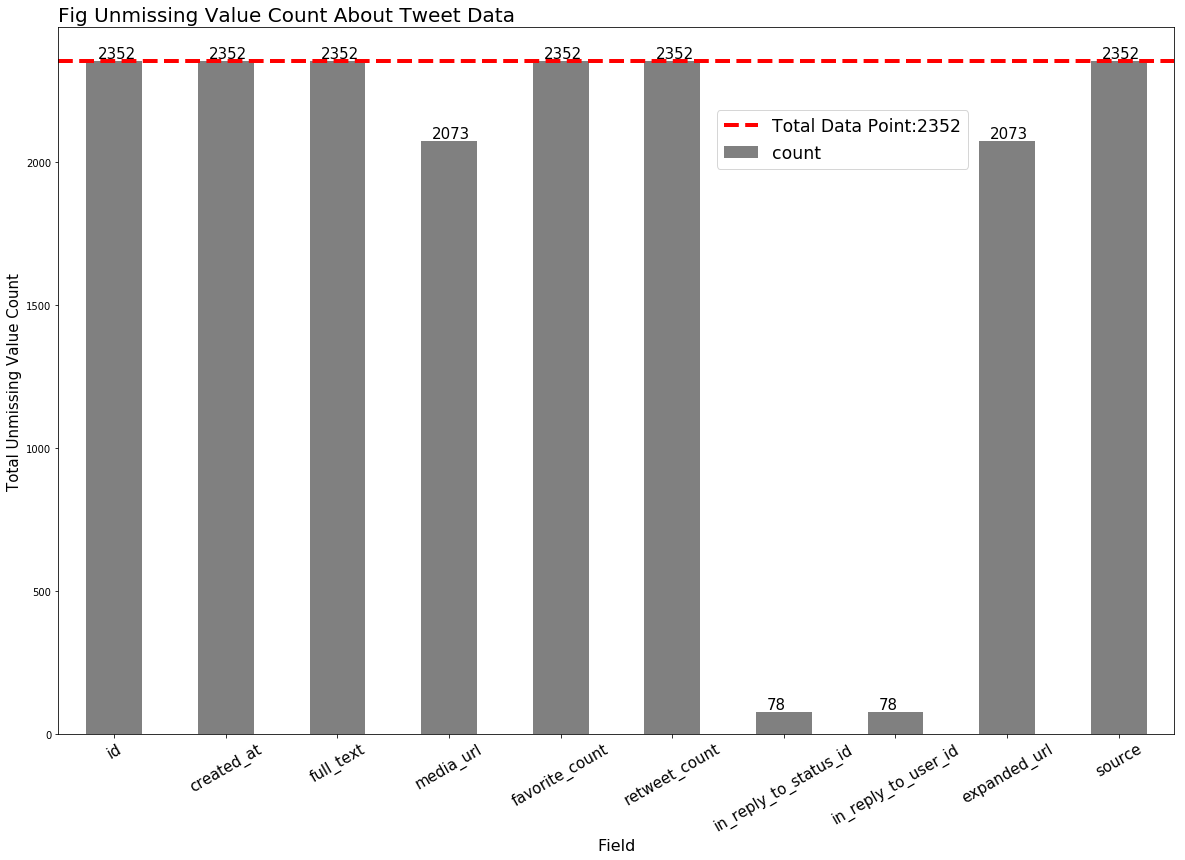

In [20]:
# plot the missing value hist plot
x_axis = tweet_data.columns.get_values()
height = len(tweet_data) - tweet_data.isnull().sum()
hist_data = pd.DataFrame({"field": height.index.values, "count":height.values}, columns=["field", "count"])

hist_data.plot(x="field", kind="bar", figsize=(20, 13), rot=30, color="grey", legend="") #, yticks=np.arange(height.min()-500, height.max()+200, 300))
plt.xlabel("Field", fontsize=16)
loc, label = plt.xticks( fontsize=10)
plt.ylabel("Total Unmissing Value Count", fontsize=15)
plt.yticks()
plt.xticks(fontsize=15)

for x, y, s in zip(loc, [i + 10 for i in height], [str(i) for i in height]):
    plt.text(x-0.15, y, s, fontsize=15)

plt.title("Fig Unmissing Value Count About Tweet Data", loc="left", fontsize=20)
plt.hlines(y=2352, xmin=-0.5, xmax=loc.max()+1,colors="r", linestyles="--", linewidth=4,label="Total Data Point:2352")
plt.legend(loc=(0.59,0.8), fontsize="xx-large")
plt.show()

### 2. 评估数据
#### 2.2 对数据内容及数据数据类型评估
1. 对 `image_prediction_data` 进行数据内容和数据类型探索，该数据集有 `2075` 个数据且有 	`12` 个 `field`；另外发存在数据类型不合适的情况，该数据集没有缺失值的情况。

2. 对 `twitter_archive_data` 进行数据内容和数据类型探索，该数据集中有 `2356` 个数据且有 `17` 个 `field`；在数据类型不合适的情况以及该数据集某些 `field`  存在缺失值的情况—— `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` 数据缺失严重；另外在 `expanded_urls` 中存在部分数据缺失

3. 对 `tweet_data` 进行数据内容和数据类型探索，该数据集有 `10` 个 `field` 以及 `2352` 个数据点。该数据的主要问题，还是是数据类型不符合 `id`, `created_at`, `in_reply_to_status_id`, `in_reply_to_user_id`, `source`；一个行列单元格包含了多个信息， `full_text` 包括了 `tweet` 信息、评分分数以及链接。

#### 2.3 总体评估结论：
**质量**

1. `image_prediction_data` 数据集

	* `tweet_id` 是 `int64` 的整数类型，实际应当保存为 `object` 类型
	* `p1` 数据中首字母存在大写和小写混用的情况
	* `p2` 数据中首字母存在大写和小写混用的情况
	* `p3` 数据中首字母存在大写和小写混用的情况
	* `p1_conf` 是比例数据，可以确认需要保留的小数点位数
	* `p2_conf` 是比例数据，可以确认需要保留的小数点位数
	* `p3_conf` 是比例数据，可以确认需要保留的小数点位数

2. `twitter_archive_data`	数据集
	
	* `tweet_id` 是 `int64` 的整数类型，实际应当保存为 `object` 类型
	* `in_reply_to_status_id` 是 `float64` 的整数类型，实际应当保存为 `object` 类型
	* `in_reply_to_user_id` 是 `float64` 的整数类型，实际应当保存为 `object` 类型
	* `timestamp` 是 `object` 的对象数据(字符串模式)，实际应当保存为 `datetime` 类型
	* `retweeted_status_id` 是 `float64` 的数值类型数据，实际应当是 `object` 类型
	* `retweeted_status_user_id` 是 `float64` 的数值类型数据，实际应当是 `object` 类型
	* `retweeted_status_timestamp` 是 `object` 的对象数据(字符串模式)，实际应当保存为 `datetime` 类型
	* 存在缺失值: 缺少相关信息，不合适进行处理
    * `text` 存在以空字符串保存缺失值的

3. `tweet_data`	的数据集

	* `id` 是 `int64` 的整数类型，实际应当保存为 `object` 类型
	* `created_at` 是 `object` 的对象数据(字符串模式)，实际应当保存为 `datetime` 类型
    * `media_url` 中以 `None` 来保存缺失数据的情况
    * `in_reply_to_status_id` 中以 `None` 来保存缺失数据的情况
    * `in_reply_to_user_id` 中以 `None` 来保存缺失数据的情况


**整洁度**

1. `image_prediction_data` 数据集

	目前尚未发现需要调整的结构问题
	
2. `twitter_archive_data`	数据集

	* `source` 中保存了 `HTML` 标签类型数据
	* `text` 中保存了评分数据，`tweet` 文本信息以及链接数据
	* `expanded_urls` 存储了重复数据值
	* `field` 拆分为了多个，例如`doggo`,`floofer`, `pupper`, `puppo`

3. `tweet_data`	的数据集

	* `full_text` 中保存了评分数据，`tweet` 文本信息以及链接数据
	* `source` 中保存了 `HTML` 标签类型数据

In [21]:
# create the data copy
image_data_copy = copy.deepcopy(image_prediction_data)
twitter_archive_data_copy = copy.deepcopy(twitter_archive_data)
tweet_data_copy = copy.deepcopy(tweet_data)

In [22]:
print("Before wrangling data about the image data:\n")
print(image_data_copy.dtypes)

Before wrangling data about the image data:

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object


In [23]:
# `tweet_id` 是 `int64` 的整数类型，实际应当保存为 `object` 类型
image_data_copy["tweet_id"] = image_data_copy["tweet_id"].apply(str)

In [24]:
# `p1` 数据中首字母存在大写和小写混用的情况
# `p2` 数据中首字母存在大写和小写混用的情况
# `p3` 数据中首字母存在大写和小写混用的情况
image_data_copy[["p1", "p2", "p3"]] = image_data_copy[["p1", "p2", "p3"]].applymap(lambda x: x.title())

In [25]:
# `p1_conf` 是比例数据，可以确认需要保留的小数点位数
# `p2_conf` 是比例数据，可以确认需要保留的小数点位数
# `p3_conf` 是比例数据，可以确认需要保留的小数点位数
image_data_copy[["p1_conf", "p2_conf", "p3_conf"]] = image_data_copy[["p1_conf", "p2_conf", "p3_conf"]].applymap(lambda x: round(x, 4))

In [26]:
print("After wrangling data about the image data:\n")
print(image_data_copy.dtypes)

After wrangling data about the image data:

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object


In [27]:
print("Before wrangling data about the twitter archive data:\n")
print(twitter_archive_data_copy.dtypes)

Before wrangling data about the twitter archive data:

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object


In [28]:
# `tweet_id` 是 `int64` 的整数类型，实际应当保存为 `object` 类型
twitter_archive_data_copy["tweet_id"] = twitter_archive_data_copy["tweet_id"].astype(str)

In [29]:
# `in_reply_to_status_id` 是 `float64` 的整数类型，实际应当保存为 `object` 类型
# `in_reply_to_user_id` 是 `float64` 的整数类型，实际应当保存为 `object` 类型
# `retweeted_status_id` 是 `float64` 的数值类型数据，实际应当是 `object` 类型
# `retweeted_status_user_id` 是 `float64` 的数值类型数据，实际应当是 `object` 类型
twitter_archive_data_copy[["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id"]] = \
    twitter_archive_data_copy[["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id"]].applymap(
    lambda x: x if np.isnan(x) else str(x))


In [30]:
# `timestamp` 是 `object` 的对象数据(字符串模式)，实际应当保存为 `datetime` 类型
# `retweeted_status_timestamp` 是 `object` 的对象数据(字符串模式)，实际应当保存为 `datetime` 类型
twitter_archive_data_copy["timestamp"] = twitter_archive_data_copy["timestamp"].apply(pd.Timestamp)
twitter_archive_data_copy["retweeted_status_timestamp"] = twitter_archive_data_copy["retweeted_status_timestamp"].apply(pd.Timestamp)

In [31]:
def html_content(tag):
    """
    get the data from the HTML tag. Return the content of the tag
    
    Args:
    (str) tag - the HTML tag
    
    Returns:
    (str) result - the content of the HTML tag
    """ 
    soup = BeautifulSoup(tag, "lxml")
    
    result = soup.get_text()
    
    return result

In [32]:
# `source` 中保存了 `HTML` 标签类型数据
twitter_archive_data_copy["source"] = twitter_archive_data_copy["source"].apply(html_content)

source_dict = {"Twitter for iPhone":"iphone", 
               "Twitter Web Client": "web", 
               "Vine - Make a Scene": "vine",
               "TweetDeck": "deck"}

twitter_archive_data_copy["source"] = twitter_archive_data_copy["source"].map(source_dict)

In [33]:
def text_split(text, tweet_text_option=False, rating_numerator_option=False, rating_denominator_option=False):
    """
    get the rate score from the text. Return the content of the tag
    
    Args:
    (str) text - the tweet text
    
    Returns:
    (tuple) result - the tuple contains the tweet text without the 
    rate score, rate scores
    """ 
    if not text:
        return text
    
    pattern = re.compile("\s{0,1}(\d{1,})/(\d{0,3}).{0,}|\s{.*\w\s{0,1}(https://.*\w){0,1}")

    match_pattern = re.search(pattern, text)
    
    # regex the text
    if match_pattern:
        rating_numerator = int(match_pattern.group(1))
        rating_denominator = int(match_pattern.group(2))

        tweet_text = re.sub(pattern, "", text).strip()
    else:
        rating_numerator = np.nan
        rating_denominator = np.nan
        tweet_text = text
    
    # return the result
    if tweet_text_option:
        return tweet_text

    if rating_denominator_option:
        return rating_denominator

    if rating_numerator_option:
        return rating_numerator

In [34]:
# `text` 中保存了评分数据，`tweet` 文本信息以及链接数据
twitter_archive_data_copy["rating_denominator_1"] = twitter_archive_data_copy["text"].apply(lambda x: text_split(x, rating_denominator_option=True))
twitter_archive_data_copy["rating_numerator_1"] = twitter_archive_data_copy["text"].apply(lambda x: text_split(x, rating_numerator_option=True))
twitter_archive_data_copy["text"] = twitter_archive_data_copy["text"].apply(lambda x: text_split(x, tweet_text_option=True))

twitter_archive_data_copy["text"] = twitter_archive_data_copy["text"].apply(lambda x: np.NaN if x == "" else x)

In [35]:
# 验证提取到的 rating score 数据
print("The non_difference between the archive data and the extract data about the rating score:\n")
print("The non_difference about the rating denominator is %d" % \
      sum(twitter_archive_data_copy["rating_denominator"] == twitter_archive_data_copy["rating_denominator_1"]))
print("The non_difference about the rating numerator is %d" % \
      sum(twitter_archive_data_copy["rating_numerator"] == twitter_archive_data_copy["rating_numerator_1"]))

The non_difference between the archive data and the extract data about the rating score:

The non_difference about the rating denominator is 2356
The non_difference about the rating numerator is 2356


In [36]:
# `expanded_urls` 存储了重复数据值
url = []
for head, value, tail in zip(np.repeat("https://twitter.com/dog_rates/status/", len(twitter_archive_data_copy)), 
                            twitter_archive_data_copy["tweet_id"], np.repeat("/photo/1", len(twitter_archive_data_copy))):
    url.append(head+str(value)+tail)

twitter_archive_data_copy["expanded_urls"] = pd.Series(url)

In [37]:
#  `field` 拆分为了多个，例如`doggo`,`floofer`, `pupper`, `puppo`
dog_type = []
for doggo, floofer, pupper, puppo in zip(twitter_archive_data_copy["doggo"], 
                                         twitter_archive_data_copy["floofer"],
                                         twitter_archive_data_copy["pupper"],
                                         twitter_archive_data_copy["puppo"]):
    dog_type.append(doggo +  floofer + pupper + puppo)

In [38]:
twitter_archive_data_copy["dog_type"] = pd.Series(dog_type)

twitter_archive_data_copy["dog_type"] = \
    twitter_archive_data_copy["dog_type"].apply(lambda x: x.replace("None", ""))
    
twitter_archive_data_copy["dog_type"] = \
    twitter_archive_data_copy["dog_type"].apply(lambda x: np.NaN if x == "" else x)    

In [39]:
twitter_archive_data_copy.dtypes

tweet_id                                   object
in_reply_to_status_id                      object
in_reply_to_user_id                        object
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                        object
retweeted_status_user_id                   object
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
rating_denominator_1                        int64
rating_numerator_1                          int64
dog_type                                   object


In [40]:
# clean the duplicate data

twitter_archive_data_copy.drop(["doggo", "floofer", "pupper", "puppo", "rating_denominator_1", "rating_numerator_1"], axis=1, inplace=True)

In [41]:
print("After wrangling data about the twitter archive data:\n")
print(twitter_archive_data_copy.dtypes)

After wrangling data about the twitter archive data:

tweet_id                                   object
in_reply_to_status_id                      object
in_reply_to_user_id                        object
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                        object
retweeted_status_user_id                   object
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
dog_type                                   object
dtype: object


In [42]:
print("Before wrangling data about the tweet data:\n")
print(tweet_data_copy.dtypes)

Before wrangling data about the tweet data:

id                        int64
created_at               object
full_text                object
media_url                object
favorite_count            int64
retweet_count             int64
in_reply_to_status_id    object
in_reply_to_user_id      object
expanded_url             object
source                   object
dtype: object


In [43]:
# `id` 是 `int64` 的整数类型，实际应当保存为 `object` 类型
tweet_data_copy["id"] = tweet_data_copy["id"].astype(str)

In [44]:
#  `created_at` 是 `object` 的对象数据(字符串模式)，实际应当保存为 `datetime` 类型
tweet_data_copy["created_at"] = tweet_data_copy["created_at"].apply(pd.Timestamp)

In [45]:
# `full_text` 中保存了评分数据，`tweet` 文本信息以及链接数据
tweet_data_copy["rating_denominator_1"] = tweet_data_copy["full_text"].apply(lambda x: int(text_split(x, rating_denominator_option=True)))
tweet_data_copy["rating_numerator_1"] = tweet_data_copy["full_text"].apply(lambda x: int(text_split(x, rating_numerator_option=True)))
tweet_data_copy["full_text"] = tweet_data_copy["full_text"].apply(lambda x: text_split(x, tweet_text_option=True))

In [46]:
# `source` 中保存了 `HTML` 标签类型数据
tweet_data_copy["source"] = tweet_data_copy["source"].apply(html_content)

tweet_data_copy["source"] = tweet_data_copy["source"].map(source_dict)

In [47]:
# `media_url` ,`in_reply_to_status_id` 以及 `in_reply_to_user_id` 中以 `None` 来保存缺失数据的情况
tweet_data_copy[["media_url", "in_reply_to_status_id", "in_reply_to_user_id"]] = \
    tweet_data_copy[["media_url", "in_reply_to_status_id", "in_reply_to_user_id"]].applymap(lambda x: np.NaN if x==None else x)

In [48]:
print("After wrangling data about the tweet data:\n")
print(tweet_data_copy.dtypes)

After wrangling data about the tweet data:

id                                    object
created_at               datetime64[ns, UTC]
full_text                             object
media_url                             object
favorite_count                         int64
retweet_count                          int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
expanded_url                          object
source                                object
rating_denominator_1                   int64
rating_numerator_1                     int64
dtype: object


In [49]:
tweet_data_copy["expanded_url"]

0       https://twitter.com/dog_rates/status/892420643...
1       https://twitter.com/dog_rates/status/892177421...
2       https://twitter.com/dog_rates/status/891815181...
3       https://twitter.com/dog_rates/status/891689557...
4       https://twitter.com/dog_rates/status/891327558...
5       https://twitter.com/dog_rates/status/891087950...
6       https://twitter.com/dog_rates/status/890971913...
7       https://twitter.com/dog_rates/status/890729181...
8       https://twitter.com/dog_rates/status/890609185...
9       https://twitter.com/dog_rates/status/890240255...
10      https://twitter.com/dog_rates/status/890006608...
11      https://twitter.com/dog_rates/status/889880896...
12      https://twitter.com/dog_rates/status/889665388...
13      https://twitter.com/dog_rates/status/889638837...
14      https://twitter.com/dog_rates/status/889531135...
15      https://twitter.com/dog_rates/status/889278841...
16      https://twitter.com/dog_rates/status/888917238...
17      https:

### 数据清洗后流程
以上经过数据清洗的过程，详情见 [wrangle_report](./wrangle_report.md)。完成以上的数据清洗，需要将相关数据进行融合：主要从几个方面去考虑，确立 **主键** ——因为需要依据主键值 `field` 来完成数据融合，另外还需要对各个 `field` 进行调整。在确立主键将数据融合到一起之后，需要再次对数据进行检查确认。至此才能保存数据结果。经实际代码验证和文档信息解读，三个数据集中，`tweet_id` 和 `id` 可以作为数据结合的主键。

In [50]:
image_data_copy.dtypes

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [51]:
twitter_archive_data_copy.dtypes

tweet_id                                   object
in_reply_to_status_id                      object
in_reply_to_user_id                        object
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                        object
retweeted_status_user_id                   object
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
dog_type                                   object
dtype: object

In [52]:
tweet_data_copy.dtypes

id                                    object
created_at               datetime64[ns, UTC]
full_text                             object
media_url                             object
favorite_count                         int64
retweet_count                          int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
expanded_url                          object
source                                object
rating_denominator_1                   int64
rating_numerator_1                     int64
dtype: object

In [53]:
image_data_copy.columns = ['tweet_id', 'jpg_url_image', 'img_num',
                           'p1', 'p1_conf', 'p1_dog', 'p2',
                           'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']

In [54]:
twitter_archive_data_copy.columns = ['tweet_id', 'in_reply_to_status_id_archive',
                                     'in_reply_to_user_id_archive', 'timestamp',
                                     'source_archive', 'text_archive', 
                                     'retweeted_status_id_archive', 
                                     'retweeted_status_user_id_archive',
                                     'retweeted_status_timestamp_archive',
                                     'expanded_urls_archive', 'rating_numerator_archive',
                                     'rating_denominator_archive', 'name', 'dog_type']

In [55]:
tweet_data_copy.columns = ['tweet_id', 'created_at_tweet', 'text_tweet', 'jpg_url_tweet', 'favorite_count',
       'retweet_count', 'in_reply_to_status_id_tweet', 'in_reply_to_user_id_tweet',
       'expanded_urls_tweet', 'source_tweet', 'rating_denominator_tweet', 'rating_numerator_tweet']

In [56]:
data = twitter_archive_data_copy.merge(image_data_copy, on="tweet_id", how='left')
data = data.merge(tweet_data_copy, on="tweet_id", how="left")

In [57]:
data.shape

(2356, 36)

In [58]:
# assign the duplicate value into np.nan about the iamge url
duplicate_url_index = data[(data["jpg_url_image"] == data["jpg_url_tweet"]) & 
     (data["jpg_url_image"].isnull().apply(lambda x: not x) & data["jpg_url_tweet"].isnull().apply(lambda x: not x))].index

data.loc[duplicate_url_index, "jpg_url_tweet"] = np.nan

In [59]:
# drop the so many missing value
data.drop(["in_reply_to_status_id_archive", "in_reply_to_user_id_archive",
          "retweeted_status_id_archive", "retweeted_status_user_id_archive",
          "in_reply_to_status_id_tweet", "in_reply_to_user_id_tweet", 
           "expanded_urls_tweet", "source_tweet","text_tweet", 
          "rating_denominator_tweet", "rating_numerator_tweet",
          "created_at_tweet"], axis=1, inplace=True)

In [60]:
data.shape

(2356, 24)

In [61]:
# store the data
data.to_csv("./twitter_archive_master.csv", index=False)

In [62]:
data.isnull().sum()

tweet_id                                 0
timestamp                                0
source_archive                           0
text_archive                             9
retweeted_status_timestamp_archive    2175
expanded_urls_archive                    0
rating_numerator_archive                 0
rating_denominator_archive               0
name                                     0
dog_type                              1976
jpg_url_image                          281
img_num                                281
p1                                     281
p1_conf                                281
p1_dog                                 281
p2                                     281
p2_conf                                281
p2_dog                                 281
p3                                     281
p3_conf                                281
p3_dog                                 281
jpg_url_tweet                         2063
favorite_count                           4
retweet_cou

考虑到融合数据需要依照 `outer joint` 的方式进行，因此优先考虑对大数据量的数据进行融合——这样保证了数据一致性。因此分别通过两步进行了融合。融合后目前得到的数据为有 `2356` 个数据点且包含了 `36` 个 `field` 数据。但是数据依然存在以下问题，需要进行相关处理，清理之后，最终得到的数据为 `2356` 个数据点且包含了 `24` 个 `field` 数据。

In [63]:
data.dtypes

tweet_id                                           object
timestamp                             datetime64[ns, UTC]
source_archive                                     object
text_archive                                       object
retweeted_status_timestamp_archive    datetime64[ns, UTC]
expanded_urls_archive                              object
rating_numerator_archive                            int64
rating_denominator_archive                          int64
name                                               object
dog_type                                           object
jpg_url_image                                      object
img_num                                           float64
p1                                                 object
p1_conf                                           float64
p1_dog                                             object
p2                                                 object
p2_conf                                           float64
p2_dog        

In [64]:
df = pd.read_csv("twitter_archive_master.csv", header=0,
                 names=["ID", "CreateTime", "Device",
                         "Tweet", "RetweetTime", "TweetUrl",
                         "RatingNumerator", "RatingDenominator",
                         "DogName", "DogType", "ImgUrl1", "ImgNum",
                         "Pred1", "PredConf1", "PredResult1", 
                         "Pred2", "PredConf2", "PredResult2",
                         "Pred3", "PredConf3", "PredResult3",
                         "ImgUrl2", "FavoriteCount", "RetweetCount"],
                 converters={"CreateTime": pd.Timestamp,
                              "RetweetTime": pd.Timestamp,
                              "PredResult1": bool,
                              "PredResult2": bool,
                              "PredResult3": bool})

In [65]:
df = df[["ID", "CreateTime", "DogName", "DogType", 
         "RatingNumerator", "RatingDenominator",
        "FavoriteCount", "RetweetCount", "RetweetTime",
         "Device", "ImgUrl1", "ImgUrl2", "ImgNum","Tweet", 
         "TweetUrl","Pred1", "PredConf1", "PredResult1", 
         "Pred2", "PredConf2", "PredResult2", "Pred3", 
        "PredConf3", "PredResult3"]]

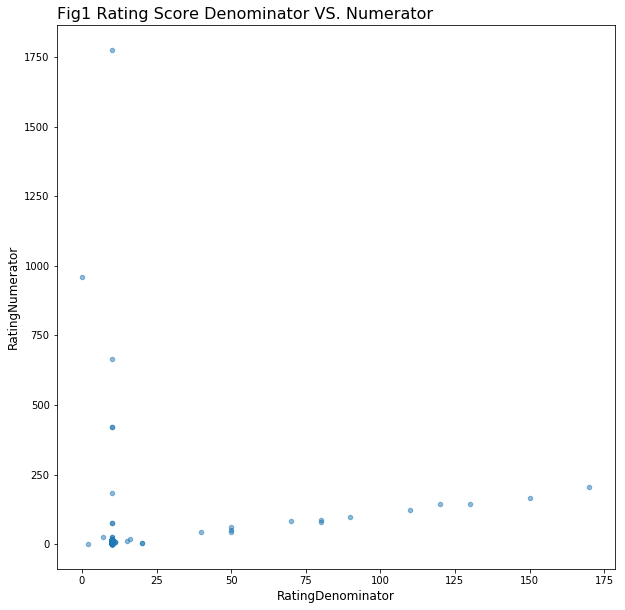

In [66]:
df.plot(x="RatingDenominator", y="RatingNumerator", kind="scatter", figsize=(10, 10), alpha=0.5, fontsize=10)
plt.title("Fig1 Rating Score Denominator VS. Numerator", loc="left", fontsize=16)
plt.xlabel("RatingDenominator", fontsize=12)
plt.ylabel("RatingNumerator", fontsize=12)
plt.show()

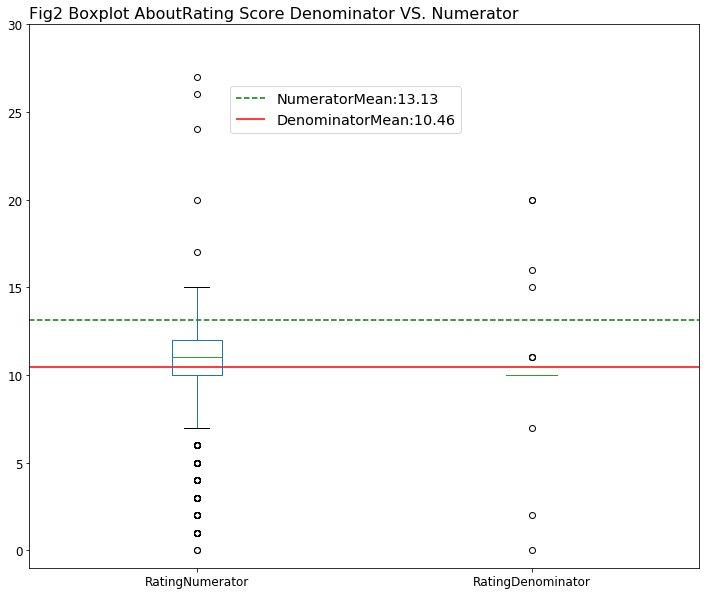

In [67]:
df[["RatingNumerator", "RatingDenominator"]].plot(kind="box", ylim=(-1, 30), figsize=(12, 10),fontsize=12)
plt.hlines(y=df["RatingNumerator"].mean(), xmin=0, xmax=3, 
           linestyles="--", color="g", label="NumeratorMean:%s"% round(df["RatingNumerator"].mean(), 2))

plt.hlines(y=df["RatingDenominator"].mean(), xmin=0, xmax=3, 
           linestyles="-", color="r", label="DenominatorMean:%s"% round(df["RatingDenominator"].mean(), 2))
plt.legend(fontsize="x-large", loc=(0.3, 0.8))

plt.title("Fig2 Boxplot AboutRating Score Denominator VS. Numerator", loc="left", fontsize=16)
plt.show()

In [68]:
from scipy.stats import skew, skewtest

In [69]:
skew(df[["RatingNumerator", "RatingDenominator"]])

array([29.75146963, 17.14143524])

In [70]:
df[["RatingNumerator", "RatingDenominator"]].corr()

,RatingNumerator,RatingDenominator
RatingNumerator,1.000000,0.150388
RatingDenominator,0.150388,1.000000


In [71]:
df[df["RatingNumerator"]<250][["RatingNumerator", "RatingDenominator"]].corr()

,RatingNumerator,RatingDenominator
RatingNumerator,1.000000,0.854158
RatingDenominator,0.854158,1.000000


未对评分数据进行处理的情况下，1）从散点图中可以看出，`RatingNumerator` 部分值得分过于高，`RatingDenominator` 也存在部分值偏斜。从统计分析偏斜度来看，两者的偏斜度分别是——前者为 `29.75`，后者为 `17.14`；2）`RatingDenominator` 的数据相对分布均匀；3）两者的皮尔逊相关系数为 `0.1504`，两者的相关性统计学上较低。

在对 `RatingNumerator` 的数据超过 `250` 的值进行清理后，在进行了一次皮尔逊相关系数分析，此次得到的值为 `0.8542` ——明显相关性增加了很多

In [72]:
df["CreateDate"] = df["CreateTime"].dt.date

In [73]:
group_ = df.groupby("CreateDate")

In [74]:
group_data = pd.concat([group_["ID"].count(), group_["FavoriteCount"].sum(), group_["RetweetCount"].sum()], axis=1)

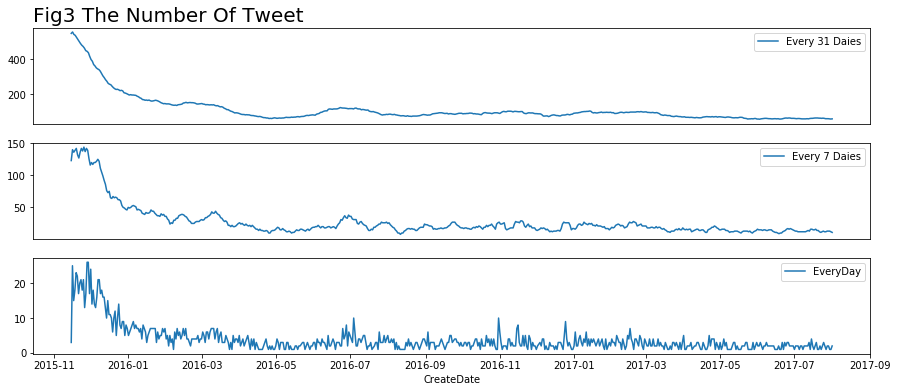

In [75]:
plt.subplot(3, 1, 1)
ax = group_data["ID"].rolling(31).sum().plot(figsize=(15, 6), label="Every 31 Daies", use_index=False)
plt.legend()
plt.title("Fig3 The Number Of Tweet", loc="left", fontsize=20)
ax.set_xticklabels("")
ax.set_xticks([])

plt.subplot(3, 1, 2)
ax = group_data["ID"].rolling(7).sum().plot(figsize=(15, 6), label="Every 7 Daies", use_index=False)
plt.legend()
ax.set_xticklabels("")
ax.set_xticks([])

plt.subplot(3, 1, 3)
group_data["ID"].plot(figsize=(15, 6), label="EveryDay")
plt.legend()

plt.show()

`Fig3` 展示的是用户 [@dog_rates](https://twitter.com/dog_rates) 随着时间变化发送 `Tweet` 的数量变化，以及分别对数据进行了移动求和处理。从以上的结果可以看出：

1. 总体上来看，该用户发 `Tweet` 的数量随着时间的变化，而逐渐减少。这点从每 7 天和每 31 天发送 `tweet` 的数量表现的比较明显
2. 即使总体上来看，该用户的在 2016 年 5 月之后发送的数量相对开始比较稳定。这可能是因为当其他用户对其信息产生黏性之后，对数量的依赖性表现的不是很明显。关于这点需要从用户点赞数量和转推数量方面去验证

/Users/renrui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


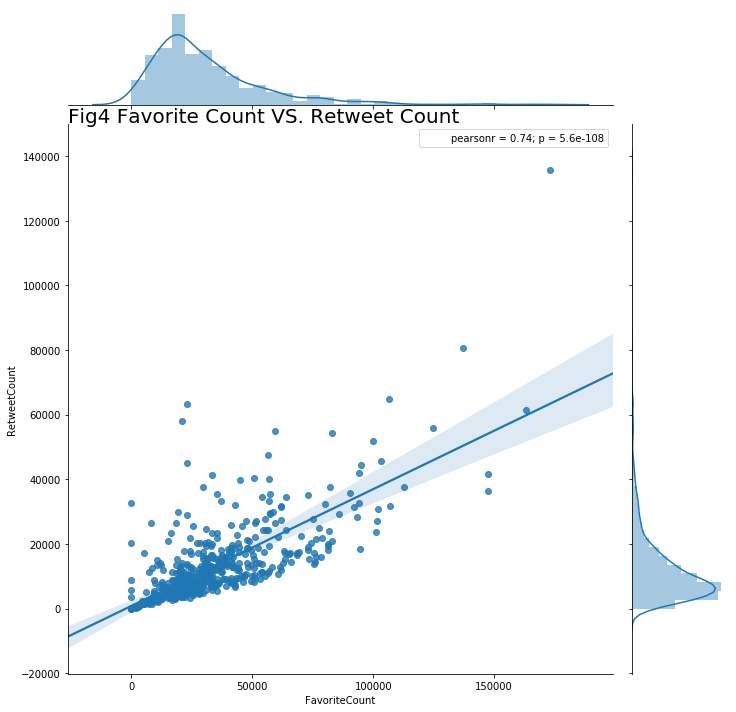

In [76]:
sn.jointplot(x="FavoriteCount", y="RetweetCount", data=group_data, kind="reg", size=10)


plt.title("Fig4 Favorite Count VS. Retweet Count", loc="left", fontsize=20, pad=2)
plt.show()

从点赞数量和转推数量展示的结果 `Fig4`，可以提出以下结论：

1. 两者都是正偏态分布的数据
2. 两者进行拟合，得到的皮尔逊相关系数值为 `0.74`，且是有统计学显著性的。因此说明了在该用户下，点赞数量和转推数量呈现出较高的相关性

In [77]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS, OLSResults, GLS

/Users/renrui/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [78]:
outcome = group_data["FavoriteCount"]
independent_variable = group_data.drop("FavoriteCount", axis=1)
# independent_variable["Intercept"] = np.repeat(1, len(group_data))

In [79]:
model = OLS(outcome, independent_variable)

In [80]:
results = model.fit()

In [81]:
print(results.fvalue)

1167.4190901801394


In [82]:
print(results.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.793     
Dependent Variable: FavoriteCount    AIC:                13641.5907
Date:               2018-06-09 17:50 BIC:                13650.4111
No. Observations:   608              Log-Likelihood:     -6818.8   
Df Model:           2                F-statistic:        1167.     
Df Residuals:       606              Prob (F-statistic): 1.39e-208 
R-squared:          0.794            Scale:              3.2381e+08
-------------------------------------------------------------------
                 Coef.   Std.Err.    t    P>|t|   [0.025    0.975] 
-------------------------------------------------------------------
ID              948.0982 166.5481  5.6926 0.0000 621.0167 1275.1796
RetweetCount      1.8885   0.0543 34.8093 0.0000   1.7819    1.9950
-------------------------------------------------------------------
Omnibus:             146.006       Durbin-Watson:          1.345  

最后以点赞数量作为自变量，而每日发 `tweet` 数量和 转推数量作为因变量进行线性拟合分析，采用的方法是使用了 `OLS` 方法进行分析。从最后的报告来看，得到了 ${R^2}$ 的值为 `0.794`，也即得到了比较高的相关性参数。从统计显著性结果来看，也是具有统计显著性的。

### 参考
1. [Tweet object — Twitter Developers](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html) 该文档对 `API` 数据的 `Field` 进行了解释，需要注意和目前得到的数据存在部分差异
2. [floating point - Why is NaN not equal to NaN? - Stack Overflow](https://stackoverflow.com/questions/10034149/why-is-nan-not-equal-to-nan?noredirect=1&lq=1)
3. [Python数据处理学习笔记 - seaborn统计数据可视化篇 — Corkine's BlOG](http://blog.mazhangjing.com/2018/03/29/learn_seaborn/#231-%E6%99%AE%E9%80%9A%E7%BA%BF%E6%80%A7%E5%85%B3%E7%B3%BB%E6%8B%9F%E5%90%88)